In [1]:
import os, csv, json, cv2, random, time, sys, shutil
import numpy as np
import pandas as pd

import multiprocessing
from joblib import Parallel, delayed

from tqdm import tqdm
from matplotlib import pyplot as plt
from zipfile import ZipFile
from PIL import Image, ImageDraw

import torch

print(sys.version)
print(torch.__version__)

3.8.8 (default, Feb 24 2021, 21:46:12) 
[GCC 7.3.0]
1.9.0a0+2ecb2c7


/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_dir = '/mnt/2015P002510/rakin/cervical_cancer/cervix_classification/portability/20230411_liger_cambodia_images_OD_retrain/SRA_cambodia_images_curated/'

In [3]:
len(os.listdir(base_dir))

484

In [4]:
!find /mnt/2015P002510/rakin/cervical_cancer/cervix_classification/portability/20230411_liger_cambodia_images_OD_retrain/SRA_cambodia_images_curated/ -type f | perl -ne 'print $1 if m/\.([^.\/]+)$/' | sort -u

jpeg
txt


In [5]:
all_files = os.listdir(base_dir)

In [6]:
final_files = all_files

print(len(final_files))

count_ext = {}
extensions = ['jpeg', 'txt']
for ext in extensions:
    count_ext[ext] = len([item for item in final_files if item[item.find('.')+1:]==ext])
    print(f'{ext}: {count_ext[ext]}')
    
print(f'total: {sum(count_ext.values())}')

484
jpeg: 242
txt: 242
total: 484


In [7]:
names = [item[:item.find('.')] for item in final_files if item[item.find('.')+1:]=='txt']

all_image_txt_present = [True if ((item + '.jpg' in final_files or item + '.jpeg' in final_files) and item + '.txt' in final_files) else False for item in names]

print(all(all_image_txt_present))

True


In [8]:
names = [item[:item.find('.')] for item in final_files]
unique_names = list(np.unique(names))

two_files = [names.count(item) for item in unique_names]
np.unique(two_files)

array([2])

# Final files logistics after removal

In [9]:
final_files = sorted(final_files)
print(len(final_files))

count_ext = {}
extensions = ['jpeg', 'txt']
for ext in extensions:
    count_ext[ext] = len([item for item in final_files if item[item.find('.')+1:]==ext])
    print(f'{ext}: {count_ext[ext]}')
    
print(f'total: {sum(count_ext.values())}')

484
jpeg: 242
txt: 242
total: 484


# Split into train/val/test 80:10:10

In [10]:
base_dir = '/mnt/2015P002510/rakin/cervical_cancer/cervix_classification/portability/20230411_liger_cambodia_images_OD_retrain/SRA_cambodia_images_curated/'
final_files = os.listdir(base_dir)
print(len(final_files))

count_ext = {}
extensions = ['jpeg', 'txt']
for ext in extensions:
    count_ext[ext] = len([item for item in final_files if item[item.find('.')+1:]==ext])
    print(f'{ext}: {count_ext[ext]}')
    
print(f'total: {sum(count_ext.values())}')

484
jpeg: 242
txt: 242
total: 484


In [11]:
final_images = [item for item in final_files if item[item.find('.')+1:] != 'txt']
final_labels = [item for item in final_files if item[item.find('.')+1:] == 'txt']

final_images = sorted(final_images)
final_labels = sorted(final_labels)

final_image_names = [item[:item.find('.')] for item in final_images]
final_label_names = [item[:item.find('.')] for item in final_labels]

print(final_image_names == final_label_names)

print(len(final_images))
print(len(final_labels))

True
242
242


In [12]:
final_image_paths = [os.path.join(base_dir, item) for item in final_images]
final_label_paths = [os.path.join(base_dir, item) for item in final_labels]

print(len(final_image_paths))
print(len(final_label_paths))

print([item[:item.find('.')] for item in final_image_paths] == [item[:item.find('.')] for item in final_label_paths])

print(final_image_paths[len(final_image_paths)-1])
print(final_label_paths[len(final_image_paths)-1])

242
242
True
/mnt/2015P002510/rakin/cervical_cancer/cervix_classification/portability/20230411_liger_cambodia_images_OD_retrain/SRA_cambodia_images_curated/MSK 000034 008.jpeg
/mnt/2015P002510/rakin/cervical_cancer/cervix_classification/portability/20230411_liger_cambodia_images_OD_retrain/SRA_cambodia_images_curated/MSK 000034 008.txt


In [13]:
# # Ordered selection

# all_image_path = final_image_paths
# all_label = final_label_paths

# pathFileTrain = all_image_path[0:int(.8*len(all_image_path))]
# pathFileValid = all_image_path[int(.8*len(all_image_path)):int(.9*len(all_image_path))]
# pathFileTest = all_image_path[int(.9*len(all_image_path)):]

# labelTrain = all_label[0:int(.8*len(all_image_path))]
# labelValid = all_label[int(.8*len(all_image_path)):int(.9*len(all_image_path))]
# labelTest = all_label[int(.9*len(all_image_path)):]

# print(
#     f"Training count: {len(pathFileTrain)}, Validation count: "
#     f"{len(pathFileValid)}, Test count: {len(pathFileTest)}")

In [14]:
# Random selection

np.random.seed(0)

all_image_path = final_image_paths
all_label = final_label_paths

val_frac = 0.1
test_frac = 0.1
length = len(all_image_path)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

pathFileTrain = [all_image_path[i] for i in train_indices]
labelTrain = [all_label[i] for i in train_indices]
pathFileValid = [all_image_path[i] for i in val_indices]
labelValid = [all_label[i] for i in val_indices]
pathFileiTest = [all_image_path[i] for i in test_indices]
labeliTest = [all_label[i] for i in test_indices]

print(
    f"Training count: {len(pathFileTrain)}, Validation count: "
    f"{len(pathFileValid)}, internal Test count: {len(pathFileiTest)}")

Training count: 194, Validation count: 24, internal Test count: 24


In [15]:
for list_1, list_2 in zip([pathFileTrain, pathFileValid, pathFileiTest],[labelTrain, labelValid, labeliTest]):
    new_list_1 = [item[:item.find('.')] for item in list_1]
    new_list_2 = [item[:item.find('.')] for item in list_2]
    print(new_list_1 == new_list_2)

True
True
True


In [17]:
base_dir = '/mnt/2015P002510/rakin/cervical_cancer/cervix_classification/portability/20230411_liger_cambodia_images_OD_retrain/SRA_cambodia_images_curated/'
dest_dir = '/mnt/2015P002510/rakin/datasets/20230411_cambodia_80_10_10/'

src_paths = [labelTrain, labelValid, labeliTest] # [pathFileTrain, pathFileValid, pathFileiTest], [labelTrain, labelValid, labeliTest]
tr_va_te = ['train','val','test']
im_la = ['images','labels']

def copy_splits(paths_to_copy, t_v_t, dest_dir, i_l):
    for item in paths_to_copy:
        dest = shutil.copy2(item, os.path.join(dest_dir, i_l, t_v_t))
    
num_cores = multiprocessing.cpu_count()
# for src_paths, t_v_t in zip([pathFileTrain, pathFileValid, pathFileiTest], ['train','val','test']):
Parallel(n_jobs=num_cores)(delayed(copy_splits)(paths_to_copy, t_v_t, dest_dir, im_la[1]) for paths_to_copy, t_v_t in zip(src_paths, tr_va_te))

[None, None, None]

In [18]:
dest_dir = '/mnt/2015P002510/rakin/datasets/20230411_cambodia_80_10_10/'
tr_va_te = ['train','val','test']

for t_v_t in tr_va_te:
    print(sorted([item[:item.find('.')] for item in os.listdir(os.path.join(dest_dir, 'images', t_v_t))]) == sorted([item[:item.find('.')] for item in os.listdir(os.path.join(dest_dir, 'labels', t_v_t))]))

True
True
True


In [19]:
# base_dir = '/mnt/2015P002510/rakin/datasets/cervix_full_dataset_detection/images'
# zip_extract_dir = '/mnt/2015P002510/rakin/datasets/20221101_full_dataset_LIGER_80_10_10/images'

# def extract_image_dir(base_dir, train_val_test, zip_extract_dir):
#     with ZipFile(os.path.join(base_dir, train_val_test + '.zip'), 'r') as zipObj:
#         zipObj.extractall(os.path.join(zip_extract_dir, train_val_test))
        
# start = time.time()

# for train_val_test in ['train', 'val', 'test', 'test2']:
#     extract_image_dir(base_dir, train_val_test, zip_extract_dir)

# end = time.time()
# print(end - start)

In [21]:
dest_dir = '/mnt/2015P002510/rakin/datasets/20221101_full_dataset_LIGER_80_10_10/'

src_paths = [labelTrain, labelValid, labeliTest] # [pathFileTrain, pathFileValid, pathFileiTest], [labelTrain, labelValid, labeliTest]
tr_va_te = ['train','val','test']
im_la = ['images','labels']

def copy_splits(paths_to_copy, t_v_t, dest_dir, i_l):
    for item in paths_to_copy:
        dest = shutil.copy2(item, os.path.join(dest_dir, i_l, t_v_t))
    
num_cores = multiprocessing.cpu_count()
# for src_paths, t_v_t in zip([pathFileTrain, pathFileValid, pathFileiTest], ['train','val','test']):
Parallel(n_jobs=num_cores)(delayed(copy_splits)(paths_to_copy, t_v_t, dest_dir, im_la[1]) for paths_to_copy, t_v_t in zip(src_paths, tr_va_te))

[None, None, None]

In [23]:
dest_dir = '/mnt/2015P002510/rakin/datasets/20221101_full_dataset_LIGER_80_10_10/'
tr_va_te = ['train','val','test']

for t_v_t in tr_va_te:
    print(sorted([item[:item.find('.')] for item in os.listdir(os.path.join(dest_dir, 'images', t_v_t))]) == sorted([item[:item.find('.')] for item in os.listdir(os.path.join(dest_dir, 'labels', t_v_t))]))

True
True
True


## Verify that the bounding box labels are correct on the image and correspond to reasonable labelling

In [2]:
def get_OD_output_dict(img_store_dir, txt_store_dir):
    image_files = [os.path.join(img_store_dir, img_file) for img_file in os.listdir(img_store_dir) if img_file[img_file.find('.')+1:] != 'txt']
    annotation_files = [image_file.replace(image_file[(image_file.find(".")):], '.txt') for image_file in image_files]
    
    record_list = []
    
    for image_file, annotation_file in zip(image_files, annotation_files):
        record = {}
        with open(annotation_file, "r") as file:
            annotation_list = file.read().split("\n")[:-1]
        #
        annotation_list = [x.split(" ") for x in annotation_list]
        annotation_list = [[float(y) for y in x ] for x in annotation_list]
        #
        img = Image.open(image_file)
        annotations = np.array(annotation_list)
        w, h = img.size
        #
        transformed_annotations = np.copy(annotations)
        transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
        transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h
        #
        transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
        transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
        transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
        transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
        #
        for ann in transformed_annotations:
            obj_cls, x1, y1, x2, y2 = ann
        #    
        record['image_path'] = image_file
        record['image'] = image_file[143:]        
        record['x1'] = round(x1)
        record['y1'] = round(y1)
        record['x2'] = round(x2)
        record['y2'] = round(y2)
        record['dataset'] = None
        #
        record_list.append(record)
    
    return record_list

In [3]:
img_store_dir = '/mnt/2015P002510/rakin/cervical_cancer/cervix_classification/portability/20230411_liger_cambodia_images_OD_retrain/SRA_cambodia_images_curated/'
txt_store_dir = '/mnt/2015P002510/rakin/cervical_cancer/cervix_classification/portability/20230411_liger_cambodia_images_OD_retrain/SRA_cambodia_images_curated/'

df_list = get_OD_output_dict(img_store_dir, txt_store_dir)

print(len(df_list))

# df_list

242


In [4]:
keys = df_list[0].keys()

with open('/mnt/2015P002510/rakin/cervical_cancer/cervix_classification/portability/20230411_liger_cambodia_images_OD_retrain/20230411_cambodia_bb.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(df_list)
    
saved_df = pd.read_csv('/mnt/2015P002510/rakin/cervical_cancer/cervix_classification/portability/20230411_liger_cambodia_images_OD_retrain/20230411_cambodia_bb.csv')
saved_df

,image_path,image,x1,y1,x2,y2,dataset
0,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000001 001.jpeg,83,154,1349,1686,NaN
1,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000001 002.jpeg,76,123,1385,1788,NaN
2,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000001 003.jpeg,67,102,1430,1791,NaN
3,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000001 004.jpeg,76,134,1430,1802,NaN
4,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000001 005.jpeg,642,534,1851,1845,NaN
...,...,...,...,...,...,...,...
237,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000034 004.jpeg,51,761,2016,2359,NaN
238,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000034 005.jpeg,74,438,2016,1691,NaN
239,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000034 006.jpeg,30,482,1946,1677,NaN
240,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000034 007.jpeg,69,248,1974,1554,NaN


In [5]:
src_dir = '/mnt/2015P002510/rakin/cervical_cancer/cervix_classification/portability/20230411_liger_cambodia_images_OD_retrain/'

train_images = os.listdir('/mnt/2015P002510/rakin/datasets/20230411_cambodia_80_10_10/images/train/')
val_images = os.listdir('/mnt/2015P002510/rakin/datasets/20230411_cambodia_80_10_10/images/val/')
test_images = os.listdir('/mnt/2015P002510/rakin/datasets/20230411_cambodia_80_10_10/images/test/')

In [6]:
saved_df.loc[saved_df['image'].isin(train_images), 'dataset'] = 'train'
saved_df.loc[saved_df['image'].isin(val_images), 'dataset'] = 'val'
saved_df.loc[saved_df['image'].isin(test_images), 'dataset'] = 'test'
saved_df = saved_df.rename(columns={"dataset": "OD_dataset"})
saved_df

,image_path,image,x1,y1,x2,y2,OD_dataset
0,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000001 001.jpeg,83,154,1349,1686,train
1,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000001 002.jpeg,76,123,1385,1788,train
2,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000001 003.jpeg,67,102,1430,1791,train
3,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000001 004.jpeg,76,134,1430,1802,train
4,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000001 005.jpeg,642,534,1851,1845,train
...,...,...,...,...,...,...,...
237,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000034 004.jpeg,51,761,2016,2359,train
238,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000034 005.jpeg,74,438,2016,1691,train
239,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000034 006.jpeg,30,482,1946,1677,train
240,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000034 007.jpeg,69,248,1974,1554,train


In [7]:
for item in np.unique(saved_df['OD_dataset'].values):
    print(f"{item} : {list(saved_df['OD_dataset'].values).count(item)}")

test : 24
train : 194
val : 24


In [8]:
saved_df.to_csv('/mnt/2015P002510/rakin/cervical_cancer/cervix_classification/portability/20230411_liger_cambodia_images_OD_retrain/20230411_cambodia_bb.csv', index=True, index_label=None)

In [3]:
df_bb = pd.read_csv('/mnt/2015P002510/rakin/cervical_cancer/cervix_classification/portability/20230411_liger_cambodia_images_OD_retrain/20230411_cambodia_bb.csv')
img_dir = '/mnt/2015P002510/rakin/cervical_cancer/cervix_classification/portability/20230411_liger_cambodia_images_OD_retrain/SRA_cambodia_images_curated/'
df_bb

,Unnamed: 0,image_path,image,x1,y1,x2,y2,OD_dataset
0,0,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000001 001.jpeg,83,154,1349,1686,train
1,1,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000001 002.jpeg,76,123,1385,1788,train
2,2,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000001 003.jpeg,67,102,1430,1791,train
3,3,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000001 004.jpeg,76,134,1430,1802,train
4,4,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000001 005.jpeg,642,534,1851,1845,train
...,...,...,...,...,...,...,...,...
237,237,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000034 004.jpeg,51,761,2016,2359,train
238,238,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000034 005.jpeg,74,438,2016,1691,train
239,239,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000034 006.jpeg,30,482,1946,1677,train
240,240,/mnt/2015P002510/rakin/cervical_cancer/cervix_...,MSK 000034 007.jpeg,69,248,1974,1554,train


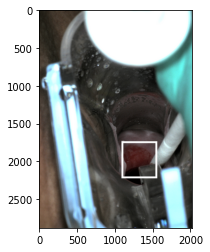

In [4]:
def plot_bounding_box(img, img_name, df_bb):
    #
    plotted_image = ImageDraw.Draw(img)
    x0 = df_bb.loc[df_bb['image']==img_name, 'x1'].values.item()
    y0 = df_bb.loc[df_bb['image']==img_name, 'y1'].values.item()
    x1 = df_bb.loc[df_bb['image']==img_name, 'x2'].values.item()
    y1 = df_bb.loc[df_bb['image']==img_name, 'y2'].values.item()
    plotted_image.rectangle(((x0,y0), (x1,y1)), outline='white', width=25)
    plotted_image.text((x0, y0 - 10), 'cervix')
    #
    plt.imshow(np.array(img))
    plt.show()

image_files = list(df_bb['image'].values)
image_file = random.choice(image_files)
image_file = 'MSK 000001 012.jpeg'

img = Image.open(os.path.join(img_dir,image_file))

#Plot the Bounding Box
plot_bounding_box(img, image_file, df_bb)

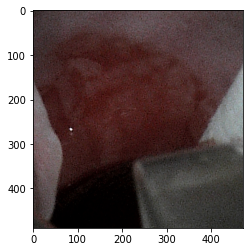

In [5]:
def crop_img(img, img_name, df_bb):
    #
    x1 = df_bb.loc[df_bb['image']==img_name, 'x1'].values.item()
    y1 = df_bb.loc[df_bb['image']==img_name, 'y1'].values.item()
    x2 = df_bb.loc[df_bb['image']==img_name, 'x2'].values.item()
    y2 = df_bb.loc[df_bb['image']==img_name, 'y2'].values.item()
    img = img[int(y1): int(y2), int(x1): int(x2)]
    #
    plt.imshow(np.array(img))
    plt.show()

# image_files = list(df_bb['image'].values)
# image_file = random.choice(image_files)
image_file = 'MSK 000001 012.jpeg'

img = np.array(Image.open(os.path.join(img_dir,image_file)))

#Plot the Bounding Box
crop_img(img, image_file, df_bb)

### Visualize correct labels have been imported into the dataset

In [16]:
def plot_bounding_box(img, annotation_list):
    annotations = np.array(annotation_list)
    w, h = img.size
    plotted_image = ImageDraw.Draw(img)
    #
    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h
    #
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    #
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)), outline='white', width=25)
        plotted_image.text((x0, y0 - 10), 'cervix')
    #
    plt.imshow(np.array(img))
    plt.show()
    

random.seed(0)

txt_store_dir = '/mnt/2015P002510/rakin/datasets/20230411_cambodia_80_10_10/labels/'

annotations = [os.path.join(txt_store_dir + 'val', txt_file) for txt_file in os.listdir(txt_store_dir + 'val') if txt_file[-3:] == "txt"]
# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]
    
annotation_file

'/mnt/2015P002510/rakin/datasets/20230411_cambodia_80_10_10/labels/val/MSK 000021 006.txt'

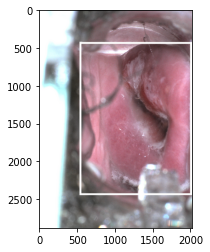

In [18]:
#Get the corresponding image file
image_file = annotation_file.replace("labels", "images").replace("txt", "jpeg")
assert os.path.exists(image_file)

#Load the image
img = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(img, annotation_list)

# Get 91 randomly chosen images from 5study test2 dataset for side by side comparison

In [19]:
# base_dir = '/mnt/2015P002510/rakin/datasets/20221101_full_dataset_LIGER_80_10_10/images/test2/'

# image_files = [os.path.join(base_dir, img_file) for img_file in os.listdir(base_dir) if img_file[img_file.find('.')+1:] != 'txt']
# image_files_91 = random.sample(image_files, 91)

# annotation_files = [image_file.replace('images','labels').replace(image_file[(image_file.find(".")):], '.txt') for image_file in image_files_91]

# dest_dir_img = '/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20221101_retrain_exp3ep100/data/5study_test2_91/images/test2/'
# dest_dir_labels = '/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20221101_retrain_exp3ep100/data/5study_test2_91/labels/test2/'

# print(all([os.path.exists(item) for item in image_files_91]))
# print(all([os.path.exists(item) for item in annotation_files]))

# print(len(image_files_91))
# print(len(annotation_files))

In [20]:
# for image_file, label_file in zip(image_files_91, annotation_files):
#     shutil.copy2(image_file, dest_dir_img)
#     shutil.copy2(label_file, dest_dir_labels)

# Train yolov5 using similar approach as before

In [2]:
# # EXP 3 - EPOCH 100 configurations (retrain using starting weights + liger only)

# !python /mnt/2015P002510/rakin/object_detection_repos/yolov5/train.py \
# --batch 16 --epochs 100 \
# --data /mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20221101_cervix_liger_80_10_10.yaml \
# --weights /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20221101_retrain_exp3ep100/exp3ep100.pt \
# --project /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20221101_retrain_exp3ep100/ \
# --name train_liger_80_10_10

In [3]:
# # EXP 3 - EPOCH 100 configurations (retrain on 5 study + liger)

# !python /mnt/2015P002510/rakin/object_detection_repos/yolov5/train.py \
# --batch 16 --epochs 100 \
# --data /mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20221101_cervix_5study_liger_80_10_10.yaml \
# --weights /mnt/2015P002510/rakin/object_detection_repos/yolov5/downloaded_models/yolov5s.pt \
# --project /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20221101_retrain_exp3ep100/ \
# --name train_5study_liger_80_10_10

# Validate/Evaluate Performance

### Liger test 91

In [2]:
!python /mnt/2015P002510/rakin/object_detection_repos/yolov5/val.py \
--weights /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_100ep_yolov5s_5study_liger_cambodia_80_10_10.pt \
--data /mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml \
--project /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_liger_test_91/ \
--name train_100ep_yolov5s_5study_liger_cambodia_80_10_10_weights

val: data=/mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml, weights=['/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_100ep_yolov5s_5study_liger_cambodia_80_10_10.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_liger_test_91/, name=train_100ep_yolov5s_5study_liger_cambodia_80_10_10_weights, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-95-g562191f torch 1.9.0a0+2ecb2c7 CUDA:0 (NVIDIA A100-PCIE-40GB MIG 3g.20gb, 19968MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_ru
               Class     Images     Labels          P     

In [1]:
!python /mnt/2015P002510/rakin/object_detection_repos/yolov5/val.py \
--weights /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_60ep_yolov5s_5study_liger_cambodia_80_10_10.pt \
--data /mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml \
--project /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_liger_test_91/ \
--name train_60ep_yolov5s_5study_liger_cambodia_80_10_10_weights

val: data=/mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml, weights=['/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_60ep_yolov5s_5study_liger_cambodia_80_10_10.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_liger_test_91/, name=train_60ep_yolov5s_5study_liger_cambodia_80_10_10_weights, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-95-g562191f torch 1.9.0a0+2ecb2c7 CUDA:0 (NVIDIA A100-PCIE-40GB MIG 3g.20gb, 19968MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_ru
val: New cache created: /mnt/2015P002510/rakin/cervical_canc

In [2]:
!python /mnt/2015P002510/rakin/object_detection_repos/yolov5/val.py \
--weights /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_v1_tf_cambodia_80_10_10.pt \
--data /mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml \
--project /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_liger_test_91/ \
--name train_v1_tf_cambodia_80_10_10_weights

val: data=/mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml, weights=['/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_v1_tf_cambodia_80_10_10.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_liger_test_91/, name=train_v1_tf_cambodia_80_10_10_weights, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-95-g562191f torch 1.9.0a0+2ecb2c7 CUDA:0 (NVIDIA A100-PCIE-40GB MIG 3g.20gb, 19968MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_ru
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 3/3 [00

In [3]:
!python /mnt/2015P002510/rakin/object_detection_repos/yolov5/val.py \
--weights /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_yolov5s_cambodia_80_10_10.pt \
--data /mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml \
--project /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_liger_test_91/ \
--name train_yolov5s_cambodia_80_10_10_weights

val: data=/mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml, weights=['/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_yolov5s_cambodia_80_10_10.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_liger_test_91/, name=train_yolov5s_cambodia_80_10_10_weights, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-95-g562191f torch 1.9.0a0+2ecb2c7 CUDA:0 (NVIDIA A100-PCIE-40GB MIG 3g.20gb, 19968MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_ru
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 3/3

### 5study test2 91

In [3]:
!python /mnt/2015P002510/rakin/object_detection_repos/yolov5/val.py \
--weights /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_100ep_yolov5s_5study_liger_cambodia_80_10_10.pt \
--data /mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml \
--project /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_5study_test2_91/ \
--name train_100ep_yolov5s_5study_liger_cambodia_80_10_10_weights

val: data=/mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml, weights=['/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_100ep_yolov5s_5study_liger_cambodia_80_10_10.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_5study_test2_91/, name=train_100ep_yolov5s_5study_liger_cambodia_80_10_10_weights, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-95-g562191f torch 1.9.0a0+2ecb2c7 CUDA:0 (NVIDIA A100-PCIE-40GB MIG 3g.20gb, 19968MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_ru
val: New cache created: /mnt/2015P002510/rakin/cervical_

In [4]:
!python /mnt/2015P002510/rakin/object_detection_repos/yolov5/val.py \
--weights /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_60ep_yolov5s_5study_liger_cambodia_80_10_10.pt \
--data /mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml \
--project /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_5study_test2_91/ \
--name train_60ep_yolov5s_5study_liger_cambodia_80_10_10_weights

val: data=/mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml, weights=['/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_60ep_yolov5s_5study_liger_cambodia_80_10_10.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_5study_test2_91/, name=train_60ep_yolov5s_5study_liger_cambodia_80_10_10_weights, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-95-g562191f torch 1.9.0a0+2ecb2c7 CUDA:0 (NVIDIA A100-PCIE-40GB MIG 3g.20gb, 19968MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_ru
               Class     Images     Labels          P     

In [5]:
!python /mnt/2015P002510/rakin/object_detection_repos/yolov5/val.py \
--weights /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_v1_tf_cambodia_80_10_10.pt \
--data /mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml \
--project /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_5study_test2_91/ \
--name train_v1_tf_cambodia_80_10_10_weights

val: data=/mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml, weights=['/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_v1_tf_cambodia_80_10_10.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_5study_test2_91/, name=train_v1_tf_cambodia_80_10_10_weights, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-95-g562191f torch 1.9.0a0+2ecb2c7 CUDA:0 (NVIDIA A100-PCIE-40GB MIG 3g.20gb, 19968MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_ru
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 3/3 [

In [6]:
!python /mnt/2015P002510/rakin/object_detection_repos/yolov5/val.py \
--weights /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_yolov5s_cambodia_80_10_10.pt \
--data /mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml \
--project /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_5study_test2_91/ \
--name train_yolov5s_cambodia_80_10_10_weights

val: data=/mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml, weights=['/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_yolov5s_cambodia_80_10_10.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_5study_test2_91/, name=train_yolov5s_cambodia_80_10_10_weights, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-95-g562191f torch 1.9.0a0+2ecb2c7 CUDA:0 (NVIDIA A100-PCIE-40GB MIG 3g.20gb, 19968MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_ru
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 3

### Cambodia test 24

In [1]:
!python /mnt/2015P002510/rakin/object_detection_repos/yolov5/val.py \
--weights /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_100ep_yolov5s_5study_liger_cambodia_80_10_10.pt \
--data /mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml \
--project /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_cambodia_test_24/ \
--name train_100ep_yolov5s_5study_liger_cambodia_80_10_10_weights

val: data=/mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml, weights=['/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_100ep_yolov5s_5study_liger_cambodia_80_10_10.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_cambodia_test_24/, name=train_100ep_yolov5s_5study_liger_cambodia_80_10_10_weights, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-95-g562191f torch 1.9.0a0+2ecb2c7 CUDA:0 (NVIDIA A100-PCIE-40GB MIG 3g.20gb, 19968MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_ru
               Class     Images     Labels          P  

In [4]:
!python /mnt/2015P002510/rakin/object_detection_repos/yolov5/val.py \
--weights /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_60ep_yolov5s_5study_liger_cambodia_80_10_10.pt \
--data /mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml \
--project /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_cambodia_test_24/ \
--name train_60ep_yolov5s_5study_liger_cambodia_80_10_10_weights

val: data=/mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml, weights=['/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_60ep_yolov5s_5study_liger_cambodia_80_10_10.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_cambodia_test_24/, name=train_60ep_yolov5s_5study_liger_cambodia_80_10_10_weights, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-95-g562191f torch 1.9.0a0+2ecb2c7 CUDA:0 (NVIDIA A100-PCIE-40GB MIG 3g.20gb, 19968MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_ru
val: New cache created: /mnt/2015P002510/rakin/cervical_c

In [5]:
!python /mnt/2015P002510/rakin/object_detection_repos/yolov5/val.py \
--weights /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_v1_tf_cambodia_80_10_10.pt \
--data /mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml \
--project /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_cambodia_test_24/ \
--name train_v1_tf_cambodia_80_10_10_weights

val: data=/mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml, weights=['/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_v1_tf_cambodia_80_10_10.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_cambodia_test_24/, name=train_v1_tf_cambodia_80_10_10_weights, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-95-g562191f torch 1.9.0a0+2ecb2c7 CUDA:0 (NVIDIA A100-PCIE-40GB MIG 3g.20gb, 19968MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_ru
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 1/1 

In [6]:
!python /mnt/2015P002510/rakin/object_detection_repos/yolov5/val.py \
--weights /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_yolov5s_cambodia_80_10_10.pt \
--data /mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml \
--project /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_cambodia_test_24/ \
--name train_yolov5s_cambodia_80_10_10_weights

val: data=/mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20220412_test.yaml, weights=['/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_yolov5s_cambodia_80_10_10.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/val_cambodia_test_24/, name=train_yolov5s_cambodia_80_10_10_weights, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-95-g562191f torch 1.9.0a0+2ecb2c7 CUDA:0 (NVIDIA A100-PCIE-40GB MIG 3g.20gb, 19968MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_ru
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 

# Export Model

In [1]:
# imgsz 320

!python /mnt/2015P002510/rakin/object_detection_repos/yolov5/export_rakin.py \
--data /mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20221101_cervix_5study_liger_80_10_10.yaml \
--weights /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_100ep_yolov5s_5study_liger_cambodia_80_10_10.pt \
--imgsz 320 320 \
--include tflite --int8

export_rakin: data=/mnt/2015P002510/rakin/object_detection_repos/yolov5/data/20221101_cervix_5study_liger_80_10_10.yaml, weights=/mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_100ep_yolov5s_5study_liger_cambodia_80_10_10.pt, imgsz=[320, 320], batch_size=1, device=cpu, half=False, inplace=False, train=False, optimize=False, int8=True, dynamic=False, simplify=False, opset=13, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['tflite']
YOLOv5 🚀 v6.0-95-g562191f torch 1.9.0a0+2ecb2c7 CPU

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from /mnt/2015P002510/rakin/cervical_cancer/cervix_detection/yolov5_runs/20230411_retrain_cambodia/train_100ep_yolov5s_5study_liger_cambodia_80_10_10.pt (14.4 MB)
2023-05-08 17:41:25.500516: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o